# Weighted Majority Rule for Regression 
Inspired from(UBMK)
> A. Dogan and D. Birant, "A Weighted Majority Voting Ensemble Approach for Classification," 2019 4th International Conference on Computer Science and Engineering (UBMK), Samsun, Turkey, 2019, pp. 1-6.
doi: 10.1109/UBMK.2019.8907028

Selamlar, 

Weighted Majority Rule for Regression Kodu ektedir.
1.	En iyi regressor’ın agırlıgı, diğerlerinin toplam hatası oranında arttırılıyor. En iyi regressor’ın ağırlık değişimi yeni gelene verilen onem ağırlığı alpha ve su ana kadar kullanılan veri sayısına bağlı bicimde oluyor.    Diğer regressor’ların ağırlığı, hatayadaki payları oranında azalıyor.
2.	Lınear regressıon
3.	SGD ile incremental learnıng ornegı goruluyor.

En guvenlı yaklasım sondaki SGD ile partial fit. En yeni yaklasım ilki, bize ait metod. Fakat yapay ogrenmede bir devrim değil ☺



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

np.random.seed(1)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Toy data

In [2]:
n = 200
ensemble = pd.DataFrame()
ensemble['regressor1'] = np.random.choice(100, n)
ensemble['regressor2'] = np.random.choice(100, n)
ensemble['regressor3'] = np.random.choice(100, n)
ensemble['regressor4'] = np.random.choice(100, n)

real_weigths = np.array([0.1, 0.1, 0.5, 0.3])

X = ensemble.values
y = np.round(X.dot(real_weigths) + 10 * np.random.randn(n))

data = ensemble.copy()
data['target'] = y

data.head()

,regressor1,regressor2,regressor3,regressor4,target
0,37,40,35,12,4.0
1,12,78,41,17,29.0
2,72,45,81,71,77.0
3,9,87,2,91,33.0
4,75,16,85,7,57.0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

X_train_ensemble = pd.DataFrame(X_train, columns=ensemble.columns)
X_test_ensemble = pd.DataFrame(X_test, columns=ensemble.columns)

### Weight Update Rule

After evaluationg the performance of regressor $r_{j}$ on $j^{th}$ instance,

\begin{align*} 
\Delta^{i}_j &= \frac{\sum_{k \neq j}|y^{i} - r^{i}_k|}{\sum_{k}|y^{i} - r^{i}_k|} \\
w^{i}_j  &=  w^{i-1}_j  + \alpha \Delta^{i}_j  
\end{align*}

### Update

winner regressor's weight gets extra delta points.
 - every looser regressor's weight loose points proportional their mistakes,
 - totally loosers loose delta points (equal to what winner gets)

### Example

|         | R1  | R2  | R3  | R4  | H  |
|---------|-----|-----|-----|-----|----|
| pred    | 30  | 30  | 70  | 30  | 60 |
| error   | 30  | 30  | 10  | 30  |    |
| +weight | 0   | 0   | 0.9 | 0   |    |


after nine examples
 - previous w3 = 0.3
 - alpha = 1
 
new_w3 = (9 *  0.3 + 1 * 0.9) = 0.36
delta_w3 = 0.06


|         | R1  | R2  | R3  | R4  | H  |
|---------|-----|-----|-----|-----|----|
| delta | -0.02 | -0.02 | 0.06  | -0.02 |    |




In [4]:
class combine_reg():
    def __init__(self, ensemble, y):
        self.ensemble = ensemble
        self.y = y
        self.n_instances = ensemble.shape[0]
        self.n_regressors = ensemble.shape[1]
        
        self.weights = pd.DataFrame()
        for c in self.ensemble.columns:
            self.weights[c] = [1/self.n_regressors]
        self.weights
        
    def fit(self, alpha = 0.1, k = 1, epochs = 5):
        for e in range(epochs):
            # at each epoch we shuffle our daata
            reindex = self.ensemble.sample(self.n_instances, random_state=1).index
            self.ensemble = self.ensemble.iloc[reindex].reset_index(drop=True)
            self.y = self.y[reindex]
            
            for i in range(self.n_instances):
                # for every instance we compute new weight
                new_weight = self.update(alpha = alpha, i = i, k = k)
                self.weights = self.weights.append(new_weight,ignore_index=True)
    
    def update(self, alpha, i, k):
        """
        winner regressor's weight gets extra delta points.
            every looser regressor's weight loose points proportional their mistakes,
            totally loosers loose delta points (equal to what winner gets)
        """
        instance_i = self.ensemble.iloc[i]
        errors_i = np.power(abs(instance_i - self.y[i]),k) # [20, 20,  5, 55]
        
        winner = errors_i.idxmin()
        others_error = errors_i.sum() - errors_i[winner]

        winner_prev_weigt = self.weights.iloc[i][winner]
        winner_weigth_i = others_error / errors_i.sum()

        winner_new_weight = ((i+1) * winner_prev_weigt +  alpha * winner_weigth_i)/(i+1+alpha)
        delta = winner_new_weight - winner_prev_weigt

        new_weigths = self.weights.iloc[i] - delta * errors_i / others_error
        new_weigths[winner] = winner_new_weight
        return new_weigths        
    
    def predict(self, X_test_ensemble):
        w_pred = self.getNormalizedWeights()
        return X_test_ensemble.values.dot(w_pred)
    
    def getNormalizedWeights(self):
        w = self.weights.iloc[-1]
        w = w/w.sum()
        return w.values

## hypersearch

In [5]:
def hyper_search(alpha_range = np.linspace(0.01,5.01,20), 
                 k_range = np.linspace(0.0,2,10)):
    
    hyper = pd.DataFrame(columns = ['a', 'k', 'err'])
    for a in alpha_range:
        for k in k_range:
            cr = combine_reg(ensemble = X_train_ensemble, y = y_train)
            cr.fit(alpha = a, k = k, epochs = 1)

            err = mean_squared_error(cr.predict(X_test_ensemble), y_test)
            hyper = hyper.append({'a':a, 'k':k, 'err':err}, ignore_index=True)
            
    a_best, k_best, err = hyper.iloc[hyper['err'].idxmin()]

    plt.plot(hyper[hyper['k'] == k_best]['a'], hyper[hyper['k'] == k_best]['err'])
    plt.xlabel('a')
    plt.show()
            
    return a_best, k_best, err, hyper

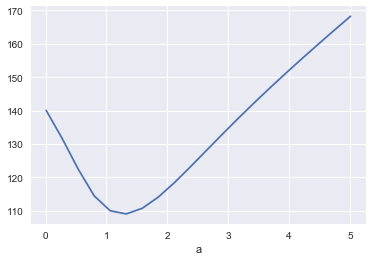

(1.3257894736842104, 0.2222222222222222, 109.05701621846279)

In [6]:
a_best, k_best, err, hyper = hyper_search()
a_best, k_best, err

In [7]:
cr_best = combine_reg(ensemble = X_train_ensemble, y = y_train)
cr_best.fit(alpha = a_best, k = k_best, epochs = 1)

err = mean_squared_error(cr_best.predict(X_test_ensemble), y_test)
print('Error ', err)
w = cr_best.getNormalizedWeights()
w

Error  109.05701621846279


array([0.20983653, 0.02343852, 0.41912885, 0.3475961 ])

## Sklearn

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train_ensemble, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

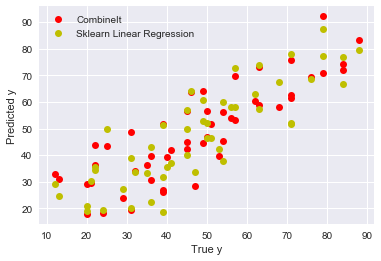

In [9]:
y_pred = lr.predict(X_test_ensemble)
#plt.plot(y, cr.predict(ensemble.values), 'go', label = 'Reward Everyone')
plt.plot(y_test, cr_best.predict(X_test_ensemble), 'ro', label = 'CombineIt')
plt.plot(y_test, y_pred, 'yo', label = 'Sklearn Linear Regression')
plt.xlabel('True y');plt.ylabel('Predicted y');
plt.legend()
plt.show()

In [10]:
lr.coef_

array([0.11341206, 0.09790537, 0.50337708, 0.29100413])

In [11]:
cr_best.weights.tail(6)

,regressor1,regressor2,regressor3,regressor4
145,0.215982,0.029484,0.405722,0.348812
146,0.214636,0.028520,0.409714,0.347131
147,0.213243,0.027326,0.413741,0.345689
148,0.212061,0.025993,0.412301,0.349644
149,0.210961,0.024730,0.415701,0.348608
150,0.209837,0.023439,0.419129,0.347596


In [12]:
sk_err = mean_squared_error(lr.predict(X_test_ensemble), y_test)
sk_err

112.01156463874322

# SGD Incremental Learning

> Real data, apart from being messy, can also be quite big in data science — sometimes so big that it can’t fit in memory,

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data

from sklearn.linear_model import SGDRegressor
SGD = SGDRegressor()

improvements = list()
chunksize = 10

for e in range(100):
    for chunk in [i*chunksize for i in range(X_train.shape[0]//chunksize)]:
        X_chunk = X_train[chunk: chunk + chunksize]
        y_chunk = y_train[chunk: chunk + chunksize].reshape(-1,1)

        SGD.partial_fit(X_chunk, y_chunk)
        improvements.append(mean_squared_error(y_test, SGD.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

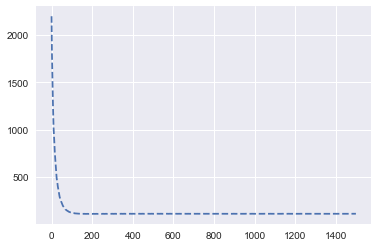

In [14]:
plt.plot(improvements,'--')
plt.show()

In [15]:
improvements[-10:]

[111.75819679270306,
 111.88618038388054,
 111.90239467514826,
 111.71305908768699,
 111.83937826808264,
 112.36642311969769,
 112.37316645880357,
 112.383681921834,
 112.16527696407533,
 112.3366471764451]

In [16]:
SGD.coef_/SGD.coef_.sum()

array([0.11576928, 0.09423093, 0.50043442, 0.28956536])